In [134]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
#!pip install -q pyyaml h5py

In [135]:
data = pd.read_csv('enriched_data.csv')

data.info(),data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7952 entries, 0 to 7951
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Pattern String  7952 non-null   object
 1   classification  7952 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.4+ KB


(None,
      Pattern String  classification
 0  Ends in 07:42:09               0
 1  Ends in 07:37:10               0
 2  Ends in 02:27:10               0
 3  Ends in 04:17:10               0
 4  Ends in 01:57:10               0)

In [136]:
data['classification'].replace({0:'Dark',1:'Not_Dark'}, inplace = True)

data.head(5)

,Pattern String,classification
0,Ends in 07:42:09,Dark
1,Ends in 07:37:10,Dark
2,Ends in 02:27:10,Dark
3,Ends in 04:17:10,Dark
4,Ends in 01:57:10,Dark


In [137]:
# Remove the rows where the first letter starting with ignoring characters
ignore_str = [',', '.', ';', '{', '}', '#', '/', '?', '@','$','(',')']
data = data[~data['Pattern String'].str[0].isin(ignore_str)]

# change the input text into lowercase for embedding preparation and later training
# data['Pattern String'] = data['Pattern String'].str.lower()

data.shape

(7902, 2)

## Train/Validation Split

In [138]:
X = data['Pattern String'].values
Y = data['classification'].values

from sklearn.model_selection import train_test_split

content_train, content_val, label_train, label_val = train_test_split(X, Y, test_size=0.2, random_state=1)

content_train.shape, content_val.shape, label_train.shape, label_val.shape 

((6321,), (1581,), (6321,), (1581,))

In [139]:
content_train[0]

'To be specific, we are proud to disclose the exact forms we use:'

### Encode the label labels
-----

In [140]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit(label_train)
y_train = encoder.transform(label_train)
y_val = encoder.transform(label_val)


(unique, counts) = np.unique(label_train, return_counts=True)
frequencies_y_train_label = np.asarray((unique, counts)).T

print('The frequency distribution of training y labels:\n',frequencies_y_train_label)

(unique, counts) = np.unique(label_val, return_counts=True)
frequencies_y_val_label = np.asarray((unique, counts)).T

print('The frequency distribution of validation y labels:\n',frequencies_y_val_label)



(unique, counts) = np.unique(y_train, return_counts=True)
frequencies_y_train_encoded = np.asarray((unique, counts)).T

print('The frequency distribution of training y encoded labels:\n',frequencies_y_train_encoded)

(unique, counts) = np.unique(y_val, return_counts=True)
frequencies_y_val_encoded = np.asarray((unique, counts)).T

print('The frequency distribution of validation y encoded labels:\n',frequencies_y_val_encoded)

The frequency distribution of training y labels:
 [['Dark' 849]
 ['Not_Dark' 5472]]
The frequency distribution of validation y labels:
 [['Dark' 195]
 ['Not_Dark' 1386]]
The frequency distribution of training y encoded labels:
 [[   0  849]
 [   1 5472]]
The frequency distribution of validation y encoded labels:
 [[   0  195]
 [   1 1386]]


In [141]:
y_train.shape, y_val.shape

((6321,), (1581,))

## Create a vocabulary index

In [142]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(content_train)    # Updates internal vocabulary based on a list of texts

X_train = tokenizer.texts_to_sequences(content_train)  # Transforms each text in texts to a sequence of integers with its corresponding integer value from the word_index dictionary
X_val = tokenizer.texts_to_sequences(content_val)

# The number of unique words in the whole training text
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

vocab_size

5687

In [143]:
tokenizer.word_index['end']

936

In [144]:
word_index = tokenizer.word_index

word_index

{'in': 1,
 'left': 2,
 'only': 3,
 'to': 4,
 '1': 5,
 'for': 6,
 'and': 7,
 'this': 8,
 'stock': 9,
 'the': 10,
 'all': 11,
 '2': 12,
 'your': 13,
 'on': 14,
 '5': 15,
 'a': 16,
 'accessories': 17,
 'women': 18,
 'eur': 19,
 'with': 20,
 'up': 21,
 'off': 22,
 'time': 23,
 '4': 24,
 '3': 25,
 'of': 26,
 'by': 27,
 'shein': 28,
 'limited': 29,
 'hurry': 30,
 'new': 31,
 'sold': 32,
 'sale': 33,
 '10': 34,
 'people': 35,
 'you': 36,
 'more': 37,
 'from': 38,
 'dress': 39,
 'purchased': 40,
 'order': 41,
 'item': 42,
 'see': 43,
 'products': 44,
 'shoulder': 45,
 'product': 46,
 'is': 47,
 'home': 48,
 'sweater': 49,
 'bought': 50,
 'us': 51,
 'free': 52,
 '6': 53,
 '7': 54,
 'plus': 55,
 'dresses': 56,
 'other': 57,
 'now': 58,
 'have': 59,
 'high': 60,
 '0': 61,
 '00': 62,
 'minutes': 63,
 'items': 64,
 'out': 65,
 'shop': 66,
 'shipping': 67,
 'smart': 68,
 'tv': 69,
 'drop': 70,
 'are': 71,
 '9': 72,
 'size': 73,
 'top': 74,
 'neck': 75,
 'delivery': 76,
 'hours': 77,
 'solid': 78,
 '

In [145]:
# Save the Tokenizer to disk
import joblib

joblib.dump(tokenizer, 'Presence_Tokenizer.joblib')

['Presence_Tokenizer.joblib']

In [146]:
def FindMaxLength(lst):
    maxList = max((x) for x in lst)
    maxLength = max(len(x) for x in lst )
  
    return maxList, maxLength

print('Longest sentence in training:\n',FindMaxLength(X_train))
print('Longest sentence in validation:\n',FindMaxLength(X_val))

Longest sentence in training:
 ([5664, 5665], 31)
Longest sentence in validation:
 ([5681, 2746], 27)


In [147]:
X_train[0]

[4, 171, 2685, 115, 71, 1837, 4, 2686, 10, 2687, 2688, 115, 305]

In [148]:
X_val[0]

[24, 53, 65, 26, 15, 526]

In [149]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 20

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

X_train.shape, X_val.shape

((6321, 20), (1581, 20))

## Load pre-trained word embeddings

dict mapping words (strings) to their NumPy vector representation:

In [150]:
import os
import pathlib

embeddings_index = {}
f = open('glove.840B.300d.txt', encoding='utf-8')
for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 21935 word vectors.


In [151]:
num_tokens = vocab_size
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3343 words (2343 misses)


In [152]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# CNN

In [153]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)  # input_length is the length of the sequence
x = layers.Conv1D(64, 2, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.3)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, preds)

model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 300)         1706100   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
dense_10 (Dense)             (None, None, 32)          2080      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0   

In [154]:
from keras.callbacks import EarlyStopping

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["acc"]
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.fit(X_train,y_train, batch_size=16, epochs=10, validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/10
396/396 [==============================] - 1s 3ms/step - loss: 0.2690 - acc: 0.8945 - val_loss: 0.0679 - val_acc: 0.9772
Epoch 2/10
396/396 [==============================] - 1s 2ms/step - loss: 0.0482 - acc: 0.9867 - val_loss: 0.0554 - val_acc: 0.9817
Epoch 3/10
396/396 [==============================] - 1s 2ms/step - loss: 0.0273 - acc: 0.9925 - val_loss: 0.0521 - val_acc: 0.9810
Epoch 4/10
396/396 [==============================] - 1s 2ms/step - loss: 0.0208 - acc: 0.9937 - val_loss: 0.0473 - val_acc: 0.9855
Epoch 5/10
396/396 [==============================] - 1s 1ms/step - loss: 0.0151 - acc: 0.9957 - val_loss: 0.0776 - val_acc: 0.9804
Epoch 00005: early stopping


In [155]:
prediction = model.predict(X_val)

prediction

array([[9.9999326e-01],
       [9.9954140e-01],
       [9.9978220e-01],
       ...,
       [9.5876133e-01],
       [7.3941374e-06],
       [9.9991053e-01]], dtype=float32)

In [156]:
dark = (prediction>0.5).astype('int32')

dark.shape,dark

((1581, 1),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]], dtype=int32))

In [157]:
pred = dark.flatten()

pred.shape, pred

((1581,), array([1, 1, 1, ..., 1, 0, 1], dtype=int32))

In [158]:
y_val.shape,y_val

((1581,), array([1, 1, 1, ..., 1, 0, 1]))

In [159]:
(unique, counts) = np.unique(prediction, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[3.74945728e-08 1.00000000e+00]
 [6.23418188e-08 2.00000000e+00]
 [7.71638611e-08 1.00000000e+00]
 ...
 [9.99999821e-01 1.00000000e+01]
 [9.99999881e-01 1.60000000e+01]
 [1.00000000e+00 2.18000000e+02]]


In [160]:
(unique, counts) = np.unique(pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0  168]
 [   1 1413]]


In [161]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, pred, labels=[0,1])
FN = cm[0][1]/y_val.shape[0]
FP = cm[1][0]/y_val.shape[0]

print('Confusion Matrix of the prediction results:\n', cm)
print('FN Rate: {:.4f}; FP Rate:{:.4f}'.format(FN,FP))

Confusion Matrix of the prediction results:
 [[ 166   29]
 [   2 1384]]
FN Rate: 0.0183; FP Rate:0.0013


--------
### Threshold setting to be 0.75
--------

In [162]:
thr_75 = (prediction>0.75).astype('int32')

thr_75.shape,thr_75

((1581, 1),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]], dtype=int32))

In [163]:
pred75 = thr_75.flatten()

pred75.shape, pred75

((1581,), array([1, 1, 1, ..., 1, 0, 1], dtype=int32))

In [164]:
(unique, counts) = np.unique(pred75, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0  173]
 [   1 1408]]


In [165]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, pred75, labels=[0,1])
FN = cm[0][1]/y_val.shape[0]
FP = cm[1][0]/y_val.shape[0]

print('Confusion Matrix of the prediction results:\n', cm)
print('FN Rate: {:.4f}; FP Rate:{:.4f}'.format(FN,FP))

Confusion Matrix of the prediction results:
 [[ 171   24]
 [   2 1384]]
FN Rate: 0.0152; FP Rate:0.0013


--------
### Threshold setting to be 0.9
--------

In [174]:
thr_90 = (prediction>0.90).astype('int32')

thr_90.shape,thr_90

((1581, 1),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]], dtype=int32))

In [175]:
pred90 = thr_90.flatten()

pred90.shape, pred90

((1581,), array([1, 1, 1, ..., 1, 0, 1], dtype=int32))

In [176]:
(unique, counts) = np.unique(pred90, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0  179]
 [   1 1402]]


In [177]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, pred90, labels=[0,1])
FN = cm[0][1]/y_val.shape[0]
FP = cm[1][0]/y_val.shape[0]

print('Confusion Matrix of the prediction results:\n', cm)
print('FN Rate: {:.4f}; FP Rate:{:.4f}'.format(FN,FP))

Confusion Matrix of the prediction results:
 [[ 173   22]
 [   6 1380]]
FN Rate: 0.0139; FP Rate:0.0038


--------
### Threshold of 0.5
-------

In [178]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9962
Validation Accuracy:  0.9804


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

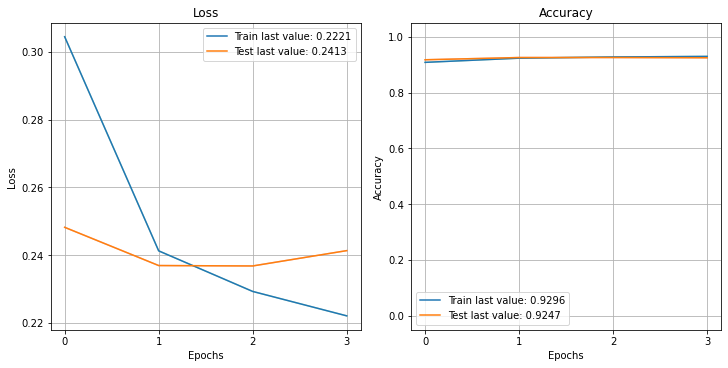

In [179]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history

plot_history(mod)

In [180]:
model.save('model_preEmb_CNN1.h5')

In [ ]:
model_reload=load_model('model_preEmb_CNN1.h5')

# CNN as an additional layer before a LSTM
--------
# Didn't change from here
-------

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, SimpleRNN
from tensorflow.keras import layers
## create model

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.LSTM(embedding_dim)(x)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(len(lyrics_train), activation="softmax")(x)
model= keras.Model(int_sequences_input, preds)
model.summary()


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mod_1=model.fit(X_train,y_train, batch_size=128, epochs=10, validation_data=(X_val,y_val),callbacks=[es])

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history
plot_history(mod_1)

In [ ]:

# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_best.h5')

In [ ]:
from tensorflow.keras.models import load_model

reload_model=load_model('model_best.h5')

In [ ]:
loss, accuracy = reload_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

RNN

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, SimpleRNN
from keras.callbacks import EarlyStopping
## create model

vocab_size=5000


#int_sequences_input = keras.Input(shape=(None,), dtype="int64")
#embedded_sequences = embedding_layer(int_sequences_input)
          # input_length is the length of the sequence
modelRNN = Sequential()
#modelCNN.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                         batch_input_shape=[None,]))
modelRNN.add(Embedding(input_dim=vocab_size,          # input_dim is the size of the vocabulary
                           output_dim=embedding_dim,      # output_dim is the size of the dense vector
                           input_length=400))
modelRNN.add(SimpleRNN(embedding_dim))
modelRNN.add(Dense(200, activation='relu'))
modelRNN.add(Dropout(0.2))
modelRNN.add(Dense(10, activation='softmax'))

modelRNN.summary()


In [ ]:
modelRNN.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mod_2=modelRNN.fit(X_train,y_train, batch_size=128, epochs=10, validation_data=(X_val,y_val), callbacks=[es])

In [ ]:
loss, accuracy = modelRNN.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelRNN.evaluate(X_val, y_val, verbose=False)
print("validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
from tensorflow.keras.models import load_model

modelRNN.save('model_RNN.h5')

In [ ]:
reload_model= keras.models.load_model("model_RNN.h5")

In [ ]:
loss, accuracy = reload_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history
plot_history(mod_2)

In [ ]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history
plot_history(mod_testRNN)

LSTM Muliple Layer

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM
from keras.callbacks import EarlyStopping
vocab_size = 5000

model06 = Sequential()
model06.add(Embedding(input_dim=vocab_size,          # input_dim is the size of the vocabulary
                           output_dim=embedding_dim,      # output_dim is the size of the dense vector
                           input_length=400))          # input_length is the length of the sequence
model06.add(LSTM(embedding_dim,return_sequences=True))
model06.add(LSTM(100, return_sequences=True))
model06.add(LSTM(100))
model06.add(Dense(200, activation='relu'))
model06.add(Dropout(0.2))
model06.add(Dense(10, activation='softmax'))

model06.summary()

In [ ]:
model06.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mod6=model06.fit(X_train,y_train, batch_size=128, epochs=10, validation_data=(X_val,y_val),callbacks=[es])

In [ ]:
loss, accuracy = model06.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model06.evaluate(X_val, y_val, verbose=False)
print("validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history
plot_history(mod6)

In [ ]:

from tensorflow.keras.models import load_model

model06.save('model_MultiL.h5')

In [ ]:
reconstructed_model = keras.models.load_model("model_MultiL.h5")


In [ ]:
loss, accuracy = model06.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

In [ ]:
prediction= reconstructed_model.predict(X_test)

In [ ]:
labels=['County','Electric','Folk','Hip-hop','Indie','Jazz','Metal','Pop','R&B','Rock']
print(prediction)
pred_str=[]
for i in range (5000):
  pred_str.append(labels[np.argmax(prediction[i])])
print(pred_str)

In [ ]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history
plot_history(mod_test6)

LSTM Single Layer

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM
from keras.callbacks import EarlyStopping
vocab_size = 5000

model05 = Sequential()
model05.add(Embedding(input_dim=vocab_size,          # input_dim is the size of the vocabulary
                           output_dim=embedding_dim,      # output_dim is the size of the dense vector
                           input_length=400))          # input_length is the length of the sequence
model05.add(LSTM(embedding_dim))
model05.add(Dense(200, activation='relu'))
model05.add(Dropout(0.2))
model05.add(Dense(10, activation='softmax'))

model05.summary()

In [ ]:
model05.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mod3=model05.fit(X_train,y_train, batch_size=128, epochs=10, validation_data=(X_val,y_val),callbacks=[es])

In [ ]:
loss, accuracy = model05.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model05.evaluate(X_val, y_val, verbose=False)
print("validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
!pip install plot_keras_history
from plot_keras_history import plot_history
plot_history(mod3)

In [ ]:
from tensorflow.keras.models import load_model

model05.save('model_SingleL.h5')

In [ ]:
reconstructed_model1 = keras.models.load_model("model_SingleL.h5")

In [ ]:
loss, accuracy = reconstructed_model1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))